# Vehicle Detection using YOLO Net

The goal here is to reproduce the task achieved using HOG features and SVM but using a special type of deep neural net called a YOLO network.

In this case YOLO stands for You Only Look Once, and has the great advantage of not requiring any preprocessing of the image. The all image is fed to the network and it is able to detect multiple objects at any location in the image.

The idea was proposed in an article by Redmon [1] and later improved by the same authors [2].
The biggest advantages of YOLO w.r.t. to other detection algorithms (including other based on deep learning) is the speed at which it can make prediction, which makes it a good candidate for real time processing on small devices.

The architecture we will implement here is slightly different than the one described in the paper, having only 9 convolutional layers, but it will be significantly faster with a relatively good accuracy.

Training such a network (even the TinyYOLO version) is quite a heavy task. To avoid, this, we will simply reuse the weights of a TinyYOLO network trained to recognize 20 differents objects, among which cars. This is a bit an overkill, since we don't need our car to recognize horses, but it will still be much more efficient than SVM's on subregions. The weights can be downloaded [here]:https://pjreddie.com/darknet/yolo/

The network will be implemented in PyTorch, for no particular reason. I justa wanted to try pytorch to give it a try.

Let's get started.

### Useful libraries

In [1]:
import glob
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from collections import OrderedDict
from scipy.misc import imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

def sigmoid(x):
    # compute sigmoid of float input
    return 1 / (1 + math.exp(-x))

### Network architecture

Next we define the architecture of the tinyYOLO network as folows :
* input : 416x416x3 image
* Conv1 : conv layer with 16 channels, filter of size 3, stride of 1 and zero padding of 1 followed by max pooling with filter size 2 and stride of 2.
* Conv2 : conv layer with 32 channels, filter of size 3, stride of 1 and zero padding of 1 followed by max pooling with filter size 2 and stride of 2.
* Conv3 : conv layer with 64 channels, filter of size 3, stride of 1 and zero padding of 1 followed by max pooling with filter size 2 and stride of 2.
* Conv4 : conv layer with 128 channels, filter of size 3, stride of 1 and zero padding of 1 followed by max pooling with filter size 2 and stride of 2.
* Conv5 : conv layer with 256 channels, filter of size 3, stride of 1 and zero padding of 1 followed by max pooling with filter size 2 and stride of 2.
* Conv6 : conv layer with 512 channels, filter of size 3, stride of 1 and zero padding of 1 followed by a specific max xpooling layer described later.
* Conv7 : conv layer with 1024 channels, filter of size 3, stride of 1 and zero padding of 1.
* Conv8 : conv layer with 1024 channels, filter of size 3, stride of 1 and zero padding of 1.
* Output : conv layer with 125 channels.

Each layer, except for the output, is followed by a batch norm layer and uses leakyRELU as an activation function.

The layer conv 6 needs a specific maxpool layer. If you compute shrinkage induced by previous pooling layers, you will find that the conv6 layer needs a padding of 0.5 which doesn't fit. The original model is implemented in C in the darknet package. There seems to be a tweak in the use of the maxpooling function : the function accepts an int for the padding parameter, but is passed a float (0.5). In the end, I don't know what's happening in darknet but the solution here was to use a specific pooling layer which pads a zero on the right and bottom of the image, and nothing at the left and top (kind of an asymmetric padding). This is implemented in the class MaxPoolStride1.

Note that we only have convolutional layers and no fully connected layers, which keeps the number of of weights minimum.

If you work out the maths, you can find that the output as a size of 125x13x13. The 125 channels provides the information on possibly detected objects : For each of the 13x13 cells, there are 5 possible boxes detected. Detection is charcterized by 25 numbers : the first five correspond to box center x, box center y, box width, box height, and logit of detection confidence. The last 20 are class confidence logits for each of the 20 classes considered in this network. 

The detection works as follows. Each one of the 13x13 grid cell is able to fit 5 different boxes. The 5 boxes shape are defined by priors (width and height), and the network makes a regression to adjust the parameters of the box : offset w.r.t to the grid cell center and dimensions. Note that the network only perform regressions, including on the binary confidence score and on the softmax for object detection. 

The class TinyYoloNet also includes methods to load the weights from a pretrained model. The model we use is based on a darknet architecture. We need two different methods, because darknet defines convolutional layers followed by batch norm as one layer. The parameters are stored as batch norm parameters followed by filter parameters. Thus we have one method for conv layer followed by batch norm, and then one method for conv layer only.


In [2]:
class MaxPoolStride1(nn.Module):
    def __init__(self):
        super(MaxPoolStride1, self).__init__()

    def forward(self, x):
        x = F.max_pool2d(F.pad(x, (0, 1, 0, 1), mode='replicate'), 2, stride=1)
        return x


class TinyYoloNet(nn.Module):
    def __init__(self, weight_file = None):
        super(TinyYoloNet, self).__init__()
        # The pretrained model we use has 20 classes
        self.num_classes = 20
        self.box_priors = [1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]
        self.num_box_priors = int(len(self.box_priors) / 2)
        self.num_output = int((5 + self.num_classes) * self.num_box_priors)
        # definition of the network
        self.cnn = nn.Sequential(OrderedDict([
            # conv1
            ('conv1', nn.Conv2d(3, 16, 3, 1, 1, bias=False)),
            ('bn1', nn.BatchNorm2d(16)),
            ('leaky1', nn.LeakyReLU(0.1, inplace=True)),
            ('pool1', nn.MaxPool2d(2, 2)),

            # conv2
            ('conv2', nn.Conv2d(16, 32, 3, 1, 1, bias=False)),
            ('bn2', nn.BatchNorm2d(32)),
            ('leaky2', nn.LeakyReLU(0.1, inplace=True)),
            ('pool2', nn.MaxPool2d(2, 2)),

            # conv3
            ('conv3', nn.Conv2d(32, 64, 3, 1, 1, bias=False)),
            ('bn3', nn.BatchNorm2d(64)),
            ('leaky3', nn.LeakyReLU(0.1, inplace=True)),
            ('pool3', nn.MaxPool2d(2, 2)),

            # conv4
            ('conv4', nn.Conv2d(64, 128, 3, 1, 1, bias=False)),
            ('bn4', nn.BatchNorm2d(128)),
            ('leaky4', nn.LeakyReLU(0.1, inplace=True)),
            ('pool4', nn.MaxPool2d(2, 2)),

            # conv5
            ('conv5', nn.Conv2d(128, 256, 3, 1, 1, bias=False)),
            ('bn5', nn.BatchNorm2d(256)),
            ('leaky5', nn.LeakyReLU(0.1, inplace=True)),
            ('pool5', nn.MaxPool2d(2, 2)),

            # conv6
            ('conv6', nn.Conv2d(256, 512, 3, 1, 1, bias=False)),
            ('bn6', nn.BatchNorm2d(512)),
            ('leaky6', nn.LeakyReLU(0.1, inplace=True)),
            ('pool6', MaxPoolStride1()),

            # conv7
            ('conv7', nn.Conv2d(512, 1024, 3, 1, 1, bias=False)),
            ('bn7', nn.BatchNorm2d(1024)),
            ('leaky7', nn.LeakyReLU(0.1, inplace=True)),

            # conv8
            ('conv8', nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)),
            ('bn8', nn.BatchNorm2d(1024)),
            ('leaky8', nn.LeakyReLU(0.1, inplace=True)),

            # output
            ('output', nn.Conv2d(1024, self.num_output, 1, 1, 0)),
        ]))
        # cast all parameters to float datatype
        self.cnn.float()
        # set the network in evaluation mode
        self.cnn.eval()
        self.weight_file = weight_file
        if weight_file:
            # buffer to the weight file
            self.buf = np.fromfile(self.weight_file, dtype=np.float32)
            # first four float number in weight file are not weights
            self.pos = 4
            self.load_weights()

    def forward(self, x):
        x = self.cnn(x)
        return x

    def load_weights(self):
        # Conv1
        self.load_conv_bn(self.cnn[0], self.cnn[1])
        # Conv2
        self.load_conv_bn(self.cnn[4], self.cnn[5])
        # Conv3
        self.load_conv_bn(self.cnn[8], self.cnn[9])
        # Conv4
        self.load_conv_bn(self.cnn[12], self.cnn[13])
        # Conv5
        self.load_conv_bn(self.cnn[16], self.cnn[17])
        # Conv6
        self.load_conv_bn(self.cnn[20], self.cnn[21])
        # Conv7
        self.load_conv_bn(self.cnn[24], self.cnn[25])
        # Conv8
        self.load_conv_bn(self.cnn[27], self.cnn[28])
        # output
        self.load_conv(self.cnn[30])

        return

    def load_conv_bn(self, conv_model, bn_model):
        num_w = conv_model.weight.numel()
        num_b = bn_model.bias.numel()
        bn_model.bias.data.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_b]))
        self.pos += num_b
        bn_model.weight.data.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_b]))
        self.pos += num_b
        bn_model.running_mean.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_b]))
        self.pos += num_b
        bn_model.running_var.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_b]))
        self.pos += num_b
        conv_model.weight.data.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_w]).view_as(conv_model.weight.data))
        self.pos += num_w

        return

    def load_conv(self, conv_model):
        num_w = conv_model.weight.numel()
        num_b = conv_model.bias.numel()
        conv_model.bias.data.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_b]))
        self.pos += num_b
        conv_model.weight.data.copy_(torch.from_numpy(self.buf[self.pos:self.pos + num_w]).view_as(conv_model.weight.data))
        self.pos += num_w

        return

    def detect(self,img):
        # convert image to torch tensor
        img = torch.from_numpy(img.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0)
        img = torch.autograd.Variable(img)
        # Make forward pass for image, and keep values as output
        output = self.cnn(img).data



        return output


To obtain usable bounding boxes and labels from the 125-long, we need to postprocess it. Each channel of the output volume (there are 13x13 of those) contains 5 stacked predictions of length 25. For each vector of length 25, we have 4 numbers computing a bounding box from one of the prior, one general detection confidence score and 20 class scores. 

The strategy is to postprocess only those 25D vectors that have a detection confidence level above a certain threshold. Then, for those positive detection, we compute the bounding box from the grid location and from the prior box size. The class label is determined by computing the softmax score of each class and keeping the maximum. Of course, since this is meant to be a vehicle detection system, we discard all positive detection that are not cars (class ID 6). 

In [3]:
def get_region_boxes(output, conf_thresh, box_priors, num_box_priors):

    batch = output.size(0)
    h = output.size(2)
    w = output.size(3)

    all_boxes = []
    for b in range(batch):
        for d in range(num_box_priors):
            conf_map = output[b, d * 25 + 4, :, :]
            conf_map = torch.sigmoid(conf_map)  # convert to [0,1] score
            detect = (conf_map > conf_thresh)  # binary tensors
            positive_loc = torch.nonzero(detect)
            for i in range(len(positive_loc)):
                cx = positive_loc[i][0]  # NOT SURE OF THE INDEXING ORDER
                cy = positive_loc[i][1]
                logits = output[b, d * 25 + 5:d * 25 + 25, cx, cy]
                # compute softmax function
                cls_confs = torch.exp(logits) / torch.sum(torch.exp(logits))
                # define most likely class
                cls_conf, cls_idx = torch.max(cls_confs, 0)
                if int(cls_idx[0])==6:  # we're only interested in cars
                    # extract box parameters prediction
                    tx = output[b, d * 25, cx, cy] # this is no longer a tensor. Float.
                    ty = output[b, d * 25+1 , cx, cy]
                    tw = output[b, d * 25 + 2, cx, cy]
                    th = output[b, d * 25 + 3, cx, cy]
                    detect_conf = output[b,d*25+4, cx, cy]
                    # transform parameter into box centers and dimensions. See YOLO9000 for these formulas.
                    # NOTE : we use cx to get y coord and vice-versa. This is due to the orientation of the axes in the
                    # image: x is horizontal, pointing to the right, and y is vertical, pointing to the bottom. In a 2D
                    # matrix, the first axis correspond to the rows, and the second to the columns. Hence, the
                    # representaiton of the image is flipped wrt. the original and we need this to get the center coord. in the image axis.
                    bx = sigmoid(tx) + cy
                    by = sigmoid(ty) + cx
                    bw = box_priors[2*d]*np.exp(tw)
                    bh = box_priors[2*d+1]*np.exp(th)
                    all_boxes.append([bx/w,by/h,bw/w,bh/h,detect_conf,cls_conf])

    return all_boxes


Now, each object can still be detected multiple times, (either by a neighbouring cell or by another box prior in the same cell). Below, we identify duplicate bounding boxes and we keep only the one that has the highest confidence interval. We identify the duplicates by computing the ratio of the area of the intersection of the two boxes and the area of their union. 


In [4]:
def remove_duplicates(boxes):
    if len(boxes)==0:
        return []
    # sort boxes by order of confidence
    det_confs = torch.zeros(len(boxes))
    for i in range(len(boxes)):
        det_confs[i] = boxes[i][4]
    _, sort_idx = torch.sort(det_confs,descending=True)
    # loop over the boxes
    sorted = [boxes[sort_idx[i]] for i in range(len(boxes))]
    remove=[]
    for i in range(len(sorted)):
        for j in range(i+1,len(sorted)):
            if boxes_overlap(sorted[i],sorted[j])>0.4:
                remove.append(j)
    unique_boxes = [sorted[i] for i in range(len(sorted)) if i not in remove]
    # loop over subsequent boxes
    # remove any box that significantly overlap the first one
    return unique_boxes

def boxes_overlap(box1,box2):
    # Here we compute a scalar indicating if two bounding boxes overlap significantly.
    # The criteria is area of the intersection of the two boxes over area of the union of the two boxes
    minx = min(box1[0] - box1[2] / 2.0, box2[0] - box2[2] / 2.0)
    maxx = max(box1[0] + box1[2] / 2.0, box2[0] + box2[2] / 2.0)
    miny = min(box1[1] - box1[3] / 2.0, box2[1] - box2[3] / 2.0)
    maxy = max(box1[1] + box1[3] / 2.0, box2[1] + box2[3] / 2.0)
    w1 = box1[2]
    h1 = box1[3]
    w2 = box2[2]
    h2 = box2[3]
    union_w = maxx - minx
    union_h = maxy - miny
    inter_w = w1 + w2 - union_w
    inter_h = h1 + h2 - union_h
    if inter_w <= 0 or inter_h <= 0:
        return 0.0

    area1 = w1 * h1
    area2 = w2 * h2
    inter_area = inter_w * inter_h
    union_area = area1 + area2 - inter_area
    return inter_area / union_area


Now all we need is subplot the bounding boxes on the original image.

In [5]:
def plot_boxes(img, boxes):
    width = img.shape[1]
    height = img.shape[0]

    #    draw = ImageDraw.Draw(img)
    for i in range(len(boxes)):
        box = boxes[i]
        # box is a tuple : (x_center,y_center,width,height,confidence,class)
        x1 = int((box[0] - box[2] / 2.0) * width)
        y1 = int((box[1] - box[3] / 2.0) * height)
        x2 = int((box[0] + box[2] / 2.0) * width)
        y2 = int((box[1] + box[3] / 2.0) * height)
        cv2.rectangle(img, (x2, y2), (x1, y1), (255, 0, 0), 4)

    return img


def plot_2_images(im1, im2, title1='Original Image', title2='Modified Image'):
    """
    Plot two images side-by-side for comparison.
    :param im1: Original image in BGR format
    :param im2: Modified image. Can be in different format 
    :param title1: Title to display above first image
    :param title2: Title to display on second image
    :return: 
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.tight_layout()
    # BGR to RGB conversion
    #ax1.imshow(im1[:, :, ::-1])
    ax1.imshow(im1)
    ax1.set_title(title1, fontsize=16)
    if len(im2.shape)==2:
        ax2.imshow(im2, cmap='gray')
    else :
        #ax2.imshow(im2[:,:,::-1])
        ax2.imshow(im2)
    ax2.set_title(title2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return ax1, ax2

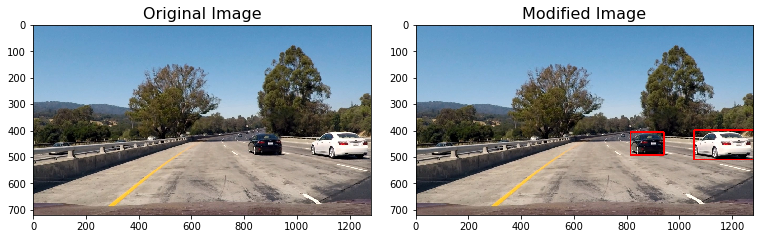

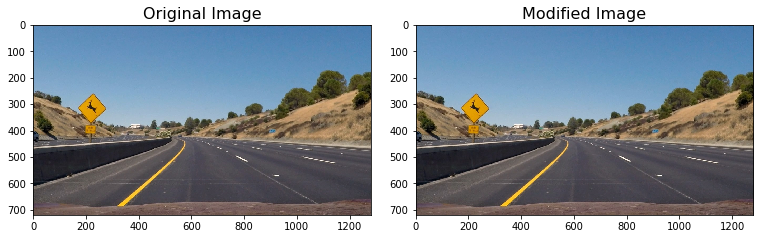

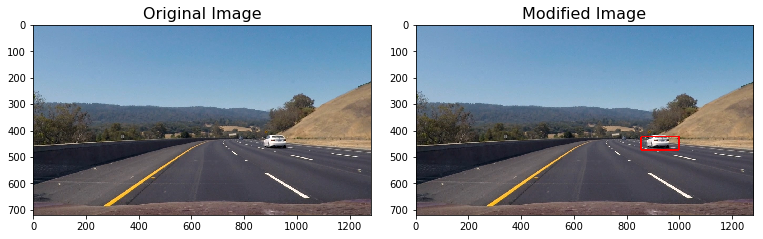

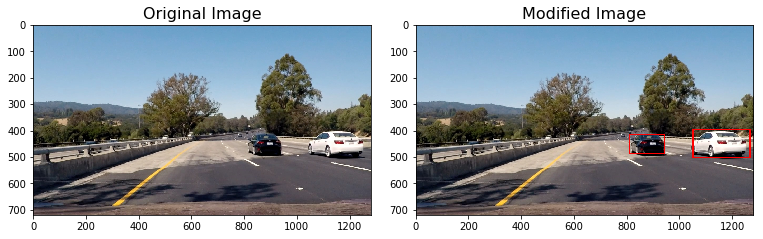

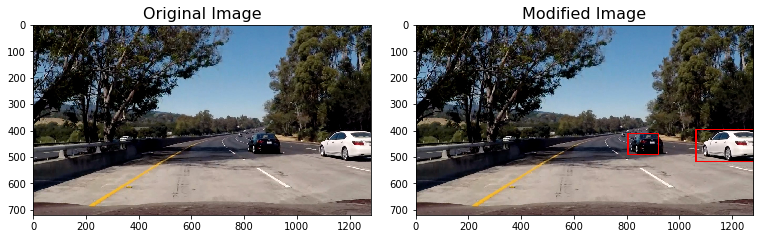

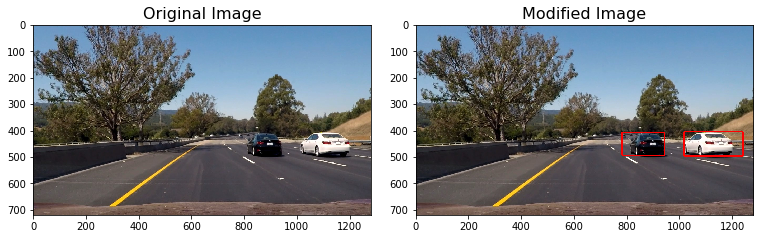

In [6]:
# Create the network
m = TinyYoloNet(weight_file='tiny-yolo-voc.weights')

img_list=glob.glob('./test_images/*.jpg')
for fname in img_list:
    test_img = mpimg.imread(fname)
    img=np.copy(test_img)
    sized = imresize(test_img, (416, 416))
    # compute output of network
    output = m.detect(sized)
    # convert out put to boxes
    conf_thresh = 0.5
    boxes = get_region_boxes(output, conf_thresh, m.box_priors, m.num_box_priors)
    boxes = remove_duplicates(boxes)
    im = plot_boxes(test_img, boxes)

    plt.figure()
    plot_2_images(img, im)


[1] You Only Look Once: Unified, Real-Time Object Detection. Redmon J., Divvala S., Girshick R., Farhadi A. 2017.
 
[2] YOLO9000: Better, Faster, Stronger. Redmon J., Farhadi A. 2017. 